# <center>ASTR4004/8004 - Simulations - Part 2</center>

This notebook builds a collisionless N-body simulation with approximate long-range forces by replacing a group of distant points with their center of mass.

The pseudocode for domain decomposition follows:
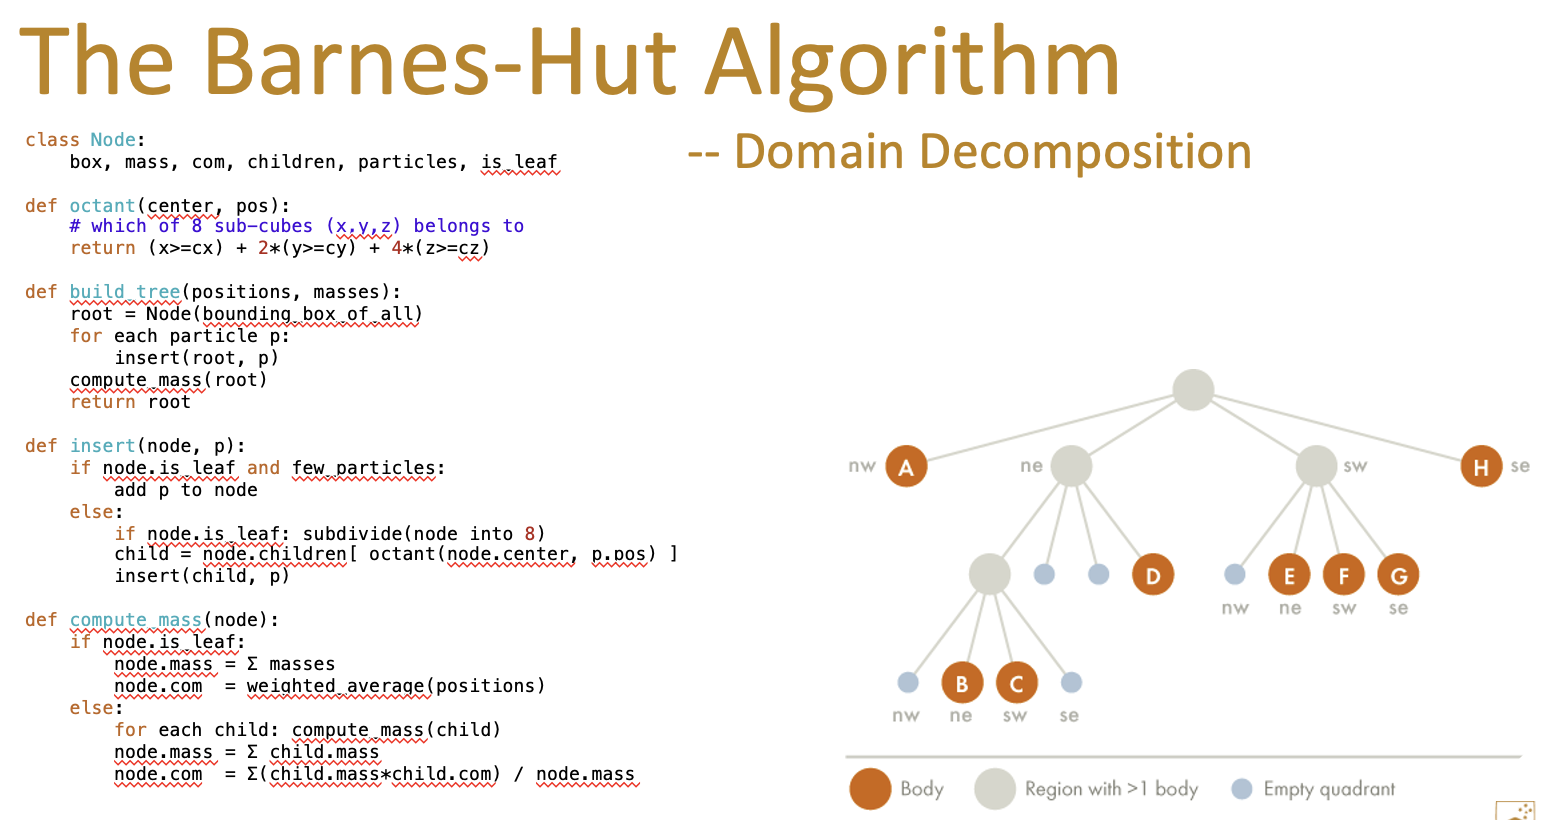

while the pseudocode for calculating the forces is:
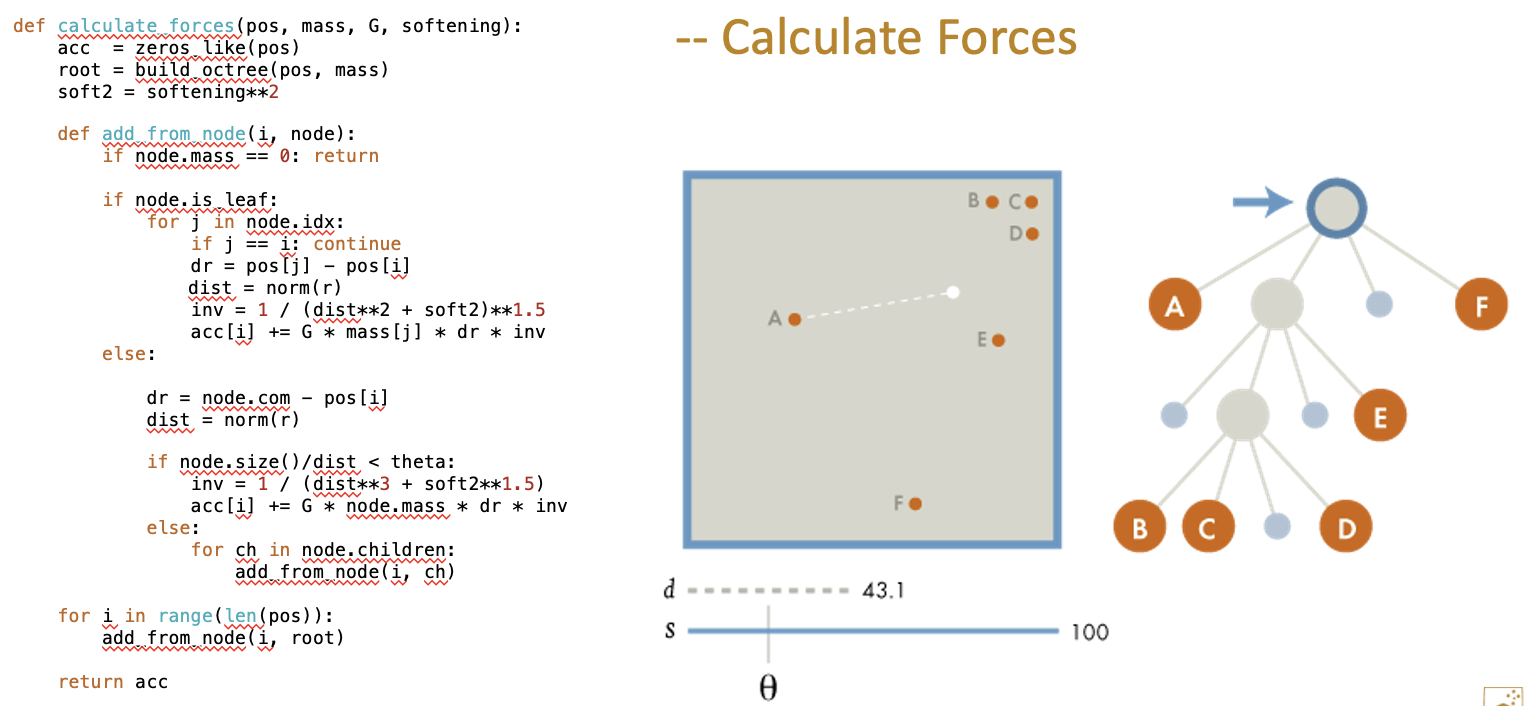


## Useful packages

In [ ]:
import matplotlib
%matplotlib ipympl
#%matplotlib inline
#from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 128

import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation
#plt.rcParams["animation.html"] = "jshtml"

In [ ]:
# Barnes–Hut tree configuration
theta = 0.6      # smaller -> more accurate (uses more node expansions), larger -> faster but less precise
max_leaf = 8     # maximum number of particles allowed in a leaf node before it splits

# In practice:
#   • smaller max_leaf -> deeper tree -> higher accuracy, slower
#   • larger max_leaf -> shallower tree -> lower accuracy, faster


class OctNode:

    """
    Represents one cube (node) in the 3D octree.

    Each node stores:
      - spatial bounds (xmin..xmax etc.)
      - total mass and center of mass of all contained particles
      - a list of particle indices if it is a leaf
      - references to up to 8 child nodes (octants)
    """

    __slots__ = ("xmin","xmax","ymin","ymax","zmin","zmax",
                 "mass","com","idx","children","is_leaf")
    def __init__(self, xmin, xmax, ymin, ymax, zmin, zmax):
        self.xmin, self.xmax = xmin, xmax
        self.ymin, self.ymax = ymin, ymax
        self.zmin, self.zmax = zmin, zmax
        self.mass = 0.0
        self.com  = np.zeros(3)     # center of mass (x,y,z)
        self.idx  = []              # particle indices (for leaf)
        self.children = [None]*8    # 8 octants
        self.is_leaf = True

    def size(self):
        """
        Characteristic node size 's' used in the Barnes–Hut opening criterion:
            s / d < θ
        where d is the distance from the particle to the node’s center of mass.
        """
        
        return max(self.xmax - self.xmin,
                   self.ymax - self.ymin,
                   self.zmax - self.zmin)

In [ ]:
def _octant_index(cx, cy, cz, x, y, z):
    """
    Determine which of the 8 octants (0–7) a point (x, y, z)
    belongs to relative to a cube center (cx, cy, cz).

    Example mapping:
        (x<cx, y<cy, z<cz) → 0
        (x>=cx, y<cy, z<cz) → 1
        (x<cx, y>=cy, z<cz) → 2
        (x>=cx, y>=cy, z<cz) → 3
        (x<cx, y<cy, z>=cz) → 4
        (x>=cx, y<cy, z>=cz) → 5
        (x<cx, y>=cy, z>=cz) → 6
        (x>=cx, y>=cy, z>=cz) → 7
    """

    ind = 
    return ind

In [ ]:
def build_octree(pos, mass, Lbox):
    """
    Construct the full Barnes–Hut octree from particle data.

    Parameters
    ----------
    pos : (N, 3) array
        Particle positions.
    mass : (N,) array
        Particle masses.
    Lbox : float
        Box size.

    Returns
    -------
    root : OctNode
        Root node of the constructed octree.

    Steps
    -----
    1. Determine the global bounding box of all particles.
    2. Create the root node covering that entire box.
    3. Insert each particle recursively into the tree.
    4. Compute total mass and center of mass for every node.
    """
    
    pos = np.asarray(pos, float)
    mass = np.asarray(mass, float).reshape(-1)

    # bounding box
    h = 0.5 * Lbox
    root = OctNode(...)

    for i in range(len(pos)):
        _insert_particle(root, pos, mass, i)

    _finalize_mass(root, pos, mass)
    return root

In [ ]:
def _insert_particle(node, pos, mass, i):
    """
    Recursively insert a single particle (index i) into the octree.

    Each node can hold up to `max_leaf` particles.
    If exceeded, the node is subdivided into 8 child octants,
    and all contained particles are reinserted into the appropriate child.
    """
    
    # Case 1: node is a leaf and has capacity -> just store this particle
    if node.is_leaf and len(node.idx) < max_leaf:
        node.idx.append(i)
        return
        
    cx = 0.5*(node.xmin + node.xmax)
    cy = 0.5*(node.ymin + node.ymax)
    cz = 0.5*(node.zmin + node.zmax)

    # Case 2: node is a leaf but full -> subdivide into 8 octants
    if node.is_leaf:
        node.is_leaf = False

        # build 8 children; ordering must match _octant_index bits
        node.children[0] = OctNode(node.xmin, cx, node.ymin, cy, node.zmin, cz)
        node.children[1] = ...
        node.children[2] = ...
        node.children[3] = ...
        
        node.children[4] = ...
        node.children[5] = ...
        node.children[6] = ...
        node.children[7] = ...
        
        # re-insert current leaf particles
        ...

    # Case 3: determine which octant this particle belongs to and recurse
    _insert_particle(node.children[...], pos, mass, i)

In [ ]:
def _finalize_mass(node, pos, mass):
    """
    Recursively compute total mass and center of mass (COM)
    for each node in the octree.

    Each node's COM and total mass are built bottom-up:
      - For leaf nodes: use the particles inside directly.
      - For internal nodes: sum the mass and weighted COM of all children.
    """
    
    # ---- Base case: leaf node ----
    if node.is_leaf:
        if node.idx:
            m = mass[node.idx].sum()
            com = (mass[node.idx][:,None] * pos[node.idx]).sum(axis=0) / m
        else:
            m = 0.0
            com = np.zeros(3)
        node.mass = m
        node.com  = com
        return

    # ---- Recursive case: internal node ----
    # what if this node already has children? 
    ...
    node.mass = m
    node.com  = com

In [ ]:
def calculate_forces(pos, mass, G, softening):
    """
    Compute gravitational accelerations using the Barnes–Hut octree.

    Parameters
    ----------
    pos : (N, 3) array
        Particle positions.
    mass : (N,) array
        Particle masses.
    G : float
        Gravitational constant.
    softening : float
        Softening length to avoid singularities at small separations.

    Returns
    -------
    acc : (N, 3) array
        Gravitational acceleration on each particle.

    Algorithm
    ----------
    For each particle:
      1. Traverse the octree.
      2. If a node is sufficiently far (s / d < θ), approximate it as one body
         using its total mass and center of mass.
      3. Otherwise, open the node and visit its children recursively.
    """

    pos = np.asarray(pos, float)
    mass = np.asarray(mass, float).reshape(-1)

    N = len(pos)
    acc = np.zeros_like(pos)
    root = build_octree(pos, mass, Lbox)

    softening2 = softening*softening

    def add_from_node(i, node):
        """Recursively accumulate gravitational acceleration from a tree node."""
        
        if node.mass == 0.0:
            return

        if node.is_leaf:
            # --- Case 1: leaf node (direct summation) ---
            ...
            
        else:
            # --- Case 2: internal node (check opening criterion) ---
            r = node.com - pos[i]
            r -= Lbox * np.round(r / Lbox) # wrap the force
            r2 = np.sum(r**2) + softening2
    
            s = node.size()
            dist = np.sqrt(r2)
            if s / dist < theta:
                # we consider everything in this node to be a distant group
                ...
            else:
                # well, we now need to go for its children
                ...

    # --- Loop over all particles ---
    for i in range(N):
        add_from_node(i, root)

    return acc

In [ ]:
# Simulation parameters
dt         = 0.01    # timestep
G          = 1.0     # Newton's Gravitational Constant

# nbody takes mass and initial position and velocity as inputs
def nbody(mass, pos0, vel0):
    
    # declare position, velocity, accelaration and time are global variables
    global pos, vel, acc, t

    pos = pos0
    vel = vel0
    t = 0      # current time of the simulation
    
    # Convert to Center-of-Mass frame
    vel -= np.mean(mass * vel,0) / np.mean(mass)
    
    # calculate initial gravitational accelerations
    acc = calculate_forces( pos, mass, G, softening )

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    h = 0.5 * Lbox
    
    ax.set(xlim=(-h, h), ylim=(-h, h))
    ax.set_aspect('equal', 'box')

    # Initialize scatter plot for positions
    scat = ax.scatter(pos[:,0],pos[:,1],s=mass*10,color='k')

    plt.tight_layout()
    
    def evolve(it):
        global pos, vel, acc, t
        
        # (1/2) kick
        vel += acc * dt/2.0
        
        # drift
        pos += vel * dt

        # apply periodic boundary conditions HERE
        pos = pos % Lbox
        pos -= Lbox/2.0

        # update accelerations
        acc = calculate_forces( pos, mass, G, softening )
        
        # (1/2) kick
        vel += acc * dt/2.0
        
        # update time
        t += dt
        
        # Update the scatter plot
        scat.set_offsets(pos[:, :2])

        return scat
        
    anim = FuncAnimation(
        fig,
        evolve,
        frames = Nframe,
        interval = interval,
        blit = False,
        repeat = True,
    )
   
    return anim

In [ ]:
# ---------------------------
# Zel'dovich toy IC generator
# ---------------------------

def zeldovich_ic(Ntot=1000, Lbox=20.0, z_init=49.0,
                 A=0.02, n_s=-2.0, k_cut=2.0):
    """
    Returns pos0, vel0 for Ntot particles in a periodic box of size Lbox.
    - P(k) ~ A * k^{n_s} * exp(-(k/k_cut)^4)  (toy spectrum)
    - EdS-like growth: D(a)=a, f(a)=1  (simple + stable)
    Units are arbitrary but consistent.
    """

    # pick a cubic grid (N = n^3)
    n = int(round(Ntot ** (1/3)))
    assert n**3 == Ntot, "Choose Ntot as a perfect cube (e.g. 10^3)."
    dx = Lbox / n
    a  = 1.0 / (1.0 + z_init)          # scale factor
    H0 = 1.0                            # set a convenient unit
    H  = H0 * a**(-1.5)                 # EdS: H(a) ~ H0 * a^{-3/2}
    D  = a                              # EdS growth
    f  = 1.0                            # EdS growth rate

    # Lattice Lagrangian positions q in [0, L)
    grid = np.stack(np.meshgrid(np.arange(n), np.arange(n), np.arange(n), indexing='ij'), axis=-1)
    q = (grid + 0.5) * dx                       # (n,n,n,3)
    q = q.reshape(-1, 3)                         # (N,3)

    # k-grid (angular frequencies)
    kx = 2*np.pi * np.fft.fftfreq(n, d=dx)
    ky = 2*np.pi * np.fft.fftfreq(n, d=dx)
    kz = 2*np.pi * np.fft.fftfreq(n, d=dx)
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    K2 = KX**2 + KY**2 + KZ**2
    K = np.sqrt(K2)
    K2[0,0,0] = 1.0   # avoid div-by-zero for the DC mode

    # Toy power spectrum P(k)
    # soft floor to avoid singularity at k=0; steep UV cut for smooth field
    Pk = A * (K + 2*np.pi/Lbox)**n_s * np.exp(-(K/(k_cut*2*np.pi/Lbox))**4)
    Pk[0,0,0] = 0.0

    # Draw a Gaussian random field δ with power P(k)
    wn = np.fft.fftn(np.random.normal(size=(n,n,n)))   # white noise in k
    delta_k = wn * np.sqrt(Pk / np.maximum(1e-30, np.mean(np.abs(wn)**2)))  # scale

    # Zel'dovich displacement field ψ_k = i k / k^2 * δ_k  (vector)
    psi_kx = 1j * KX / K2 * delta_k
    psi_ky = 1j * KY / K2 * delta_k
    psi_kz = 1j * KZ / K2 * delta_k

    # Back to real space
    psi_x = np.fft.ifftn(psi_kx).real
    psi_y = np.fft.ifftn(psi_ky).real
    psi_z = np.fft.ifftn(psi_kz).real
    psi   = np.stack([psi_x, psi_y, psi_z], axis=-1).reshape(-1,3)

    # Positions and velocities (Zel'dovich)
    pos0 = q + D * psi
    vel0 = (a * H * f * D) * psi

    # wrap into box, then center around 0 for your plotting limits
    pos0 = (pos0 % Lbox)
    pos0 -= Lbox/2.0

    return pos0, vel0


In [ ]:
np.random.seed(24)

# pick a cube: 10^3 = 1000 particles
N = 1000
Lbox = 20.0
softening = 0.05 * Lbox / (N ** (1/3))

pos0, vel0 = zeldovich_ic(Ntot=N, Lbox=Lbox, z_init=49,
                          A=0.02, n_s=-2.0, k_cut=2.0)

mass0 = (40.0 / N) * np.ones((N,1))   # keep your total mass 40

In [ ]:
Nframe     = 100    # number of simulation steps
interval   = 1      # delay between movie frames in milliseconds 

anim = nbody(mass0, pos0, vel0)
plt.close()
HTML(anim.to_jshtml())